# Gradient Boosted model with state and action vectors as input

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from load_data import load_data
from evaluate import evaluate_model
from plots import plot_degradation, plot_unique_frequencies, plot_nyquist

## Load Data

In [2]:
df = load_data("03-06-24", "A1.csv")
df.columns.values

array(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', '|Energy|/W.h',
       'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'Q charge/discharge/mA.h',
       'half cycle', 'Energy charge/W.h', 'Energy discharge/W.h',
       'Capacitance charge/µF', 'Capacitance discharge/µF', 'step time/s',
       'z cycle', 'Re(Z)/Ohm', 'Im(Z)/Ohm', 'Re(Y)/Ohm-1', 'Im(Y)/Ohm-1',
       '|Y|/Ohm-1', 'Phase(Y)/deg', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%', 'control/V',
       'control/mA', 'cycle number', 'P/W', 'R/Ohm'], dtype=object)

## Preprocess

- Filter by frequency
- I am currently unsure of whether to do >0 or > 0.2
- For now I will do 0.2 to be consistent with previous studies

In [3]:
df = df[(df['freq/Hz'] > 0.2) & (df['freq/Hz'] <= 20000)]
unique_freqs = np.array(df['freq/Hz'].unique())
unique_freqs.sort()

print(unique_freqs)

[2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.76e+01 7.50e+01 9.06e+01 1.02e+02 1.22e+02 1.35e+02
 1.63e+02 1.78e+02 2.19e+02 2.37e+02 2.94e+02 3.16e+02 3.94e+02 4.22e+02
 5.29e+02 5.64e+02 7.10e+02 7.50e+02 9.52e+02 1.00e+03 1.28e+03 1.33e+03
 1.71e+03 1.78e+03 2.30e+03 2.37e+03 3.09e+03 3.16e+03 4.14e+03 4.22e+03
 5.56e+03 5.62e+03 7.45e+03 7.50e+03 1.00e+04]


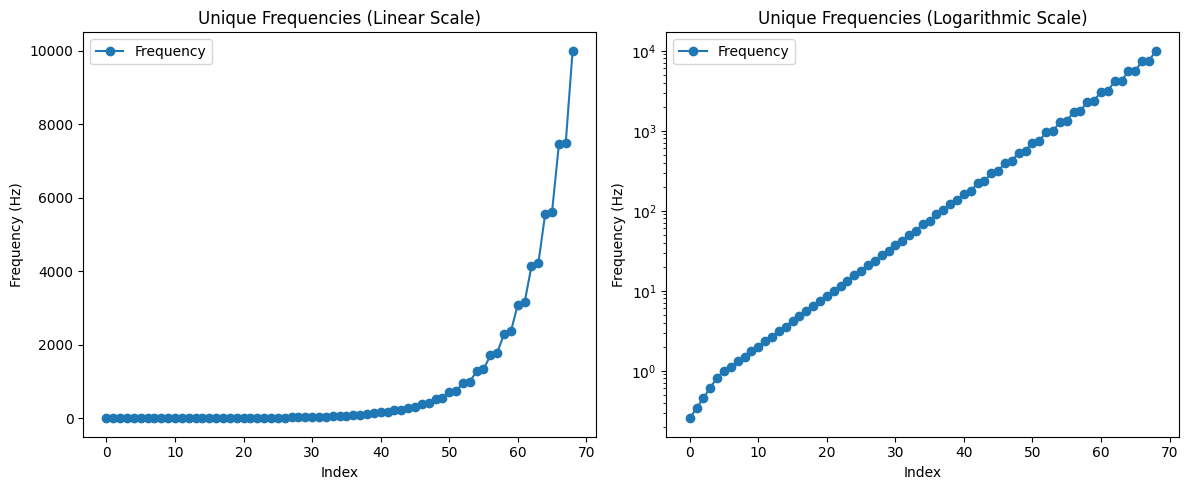

In [4]:
plot_unique_frequencies(unique_freqs)

We can see above that the unique frequencies are spaced out logarithmically, therefore we will interpolate logarithmically

### Confirm Degradation

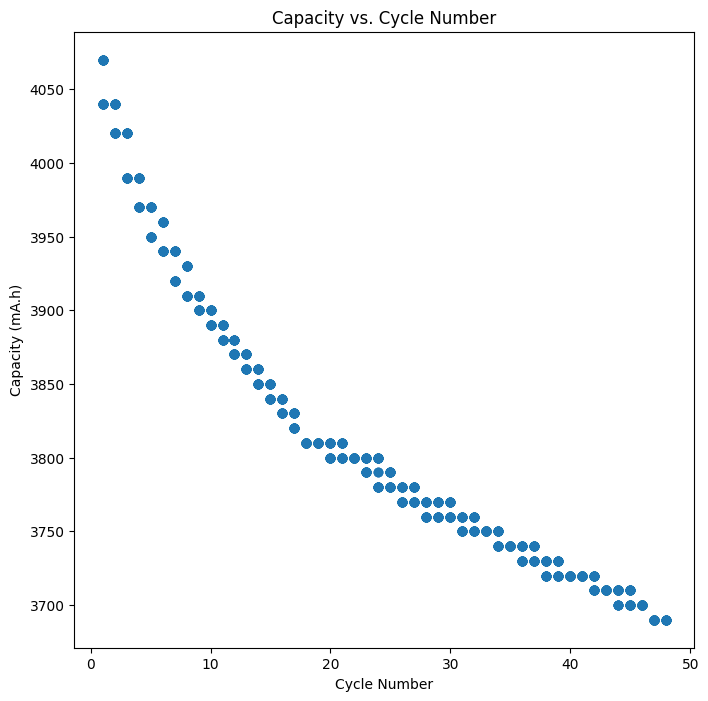

In [5]:
plot_degradation(df)

In [6]:
# Assuming df is your DataFrame
unique_freqs_by_cycle = {}

all_cycles = sorted(df['cycle number'].unique())
for cycle in all_cycles:
    cycle_freqs = np.sort(df[df['cycle number'] == cycle]['freq/Hz'].unique())
    unique_freqs_by_cycle[cycle] = cycle_freqs
    print(f"Cycle {cycle} frequency points: {cycle_freqs}")

# Compute the intersection of frequency sets
common_freqs = set(unique_freqs_by_cycle[all_cycles[0]])
for cycle in all_cycles:
    common_freqs = common_freqs.intersection(set(unique_freqs_by_cycle[cycle]))

print("Common frequency points across all cycles:", np.sort(list(common_freqs)))


Cycle 1.0 frequency points: [2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.76e+01 7.50e+01 9.06e+01 1.02e+02 1.22e+02 1.35e+02
 1.63e+02 1.78e+02 2.19e+02 2.37e+02 2.94e+02 3.16e+02 3.94e+02 4.22e+02
 5.29e+02 5.64e+02 7.10e+02 7.50e+02 9.52e+02 1.00e+03 1.28e+03 1.33e+03
 1.71e+03 1.78e+03 2.30e+03 2.37e+03 3.09e+03 3.16e+03 4.14e+03 4.22e+03
 5.56e+03 5.62e+03 7.45e+03 7.50e+03 1.00e+04]
Cycle 2.0 frequency points: [2.54e-01 3.40e-01 4.56e-01 6.12e-01 8.22e-01 9.99e-01 1.10e+00 1.33e+00
 1.48e+00 1.78e+00 1.99e+00 2.37e+00 2.66e+00 3.16e+00 3.57e+00 4.22e+00
 4.80e+00 5.62e+00 6.43e+00 7.50e+00 8.64e+00 1.00e+01 1.16e+01 1.33e+01
 1.55e+01 1.78e+01 2.09e+01 2.37e+01 2.80e+01 3.16e+01 3.75e+01 4.22e+01
 5.03e+01 5.62e+01 6.

In [7]:
unique_counts_by_cycle = {}

# Get a sorted list of unique cycle numbers.
all_cycles = sorted(df['cycle number'].unique())

# Loop through each cycle, count, and print the unique frequencies.
for cycle in all_cycles:
    # Filter the DataFrame for the current cycle and count unique frequencies
    unique_count = len(np.unique(df[df['cycle number'] == cycle]['freq/Hz']))
    unique_counts_by_cycle[cycle] = unique_count
    print(f"Cycle {cycle} has {unique_count} unique frequency points.")


Cycle 1.0 has 69 unique frequency points.
Cycle 2.0 has 69 unique frequency points.
Cycle 3.0 has 69 unique frequency points.
Cycle 4.0 has 69 unique frequency points.
Cycle 5.0 has 69 unique frequency points.
Cycle 6.0 has 69 unique frequency points.
Cycle 7.0 has 69 unique frequency points.
Cycle 8.0 has 69 unique frequency points.
Cycle 9.0 has 69 unique frequency points.
Cycle 10.0 has 69 unique frequency points.
Cycle 11.0 has 69 unique frequency points.
Cycle 12.0 has 69 unique frequency points.
Cycle 13.0 has 69 unique frequency points.
Cycle 14.0 has 69 unique frequency points.
Cycle 15.0 has 69 unique frequency points.
Cycle 16.0 has 69 unique frequency points.
Cycle 17.0 has 69 unique frequency points.
Cycle 18.0 has 69 unique frequency points.
Cycle 19.0 has 69 unique frequency points.
Cycle 20.0 has 69 unique frequency points.
Cycle 21.0 has 69 unique frequency points.
Cycle 22.0 has 69 unique frequency points.
Cycle 23.0 has 69 unique frequency points.
Cycle 24.0 has 69 un

### Building the Input
- We need a state and action vector
- State Vector $s_{n}$ - concatenated impedance values at 57 different frequencies 0.02Hz - 20kHz

### Make state vector FOR EACH CYCLE

- Build EIS-based state vectors from the given dataframe.
- Returns a dictionary keyed by cycle, where each value is another dict:
```
      {
            "labeled_impedance": dict of { "Z_re(freqHz)": val, "Z_im(freqHz)": val, ... },
            "state_vector": np.ndarray (the concatenated real+imag EIS data)
      }
```

### Action vector Data

- Build action (usage) vectors from the given dataframe.
- Typically, we treat positive I/mA as charge and negative as discharge.
- Returns a dictionary keyed by cycle, each containing a 6-element np.array: 
-     [i_charge_avg, total_charge_time, q_charge, i_discharge_avg, total_discharge_time, q_discharge]

### Combine State and Action vectors
#### Combine EIS-based state vectors and usage-based action vectors to form final (X, y) arrays.

Returns:
```
      X (np.ndarray): 2D array of shape (num_valid_cycles, dim_state + dim_action).
      y (np.ndarray): 1D array of discharge capacities for each cycle.
```

In [8]:
from SAV import (preprocess_SAV)

X, y = preprocess_SAV(df)

Most common unique frequency count is 70, so expected EIS state vector length is 140.
Skipping cycle 48.0: has 33 unique frequency points, expected 70.
Final dataset shapes:
  X: (47, 149)
  y: (47,)
X shape: (47, 149)
y shape: (47,)


## Algorithm and Model

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# X.shape -> (num_samples, num_features)
# y.shape -> (num_samples,)

# Feeding all models the same data

num_ensemble = 10
models = []
for i in range(num_ensemble):
    gb_model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=1,
        learning_rate=0.1,
        random_state=42 + i  # Use different seed for each model
    )
    models.append(gb_model)


In [10]:
# Let's do a simple train/test split to demonstrate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train each model
for m in models:
    m.fit(X_train, y_train)

# Get predictions from each model.
preds_ensemble = [model.predict(X_test) for model in models]
preds_ensemble = np.array(preds_ensemble)

# Compute ensemble predictions: mean and standard deviation.
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std = np.std(preds_ensemble, axis=0)

In [11]:
# Evaluate

from evaluate import evaluate_model

rmse, r2, mse, mae = evaluate_model(y_test, y_pred_mean)
print(f"RMSE: {rmse}\nR2: {r2}\nMSE: {mse}\nMAE: {mae}")


RMSE: 7.039197529346044
R2: 0.9905239430374543
MSE: 49.550301857151446
MAE: 5.536129570024741


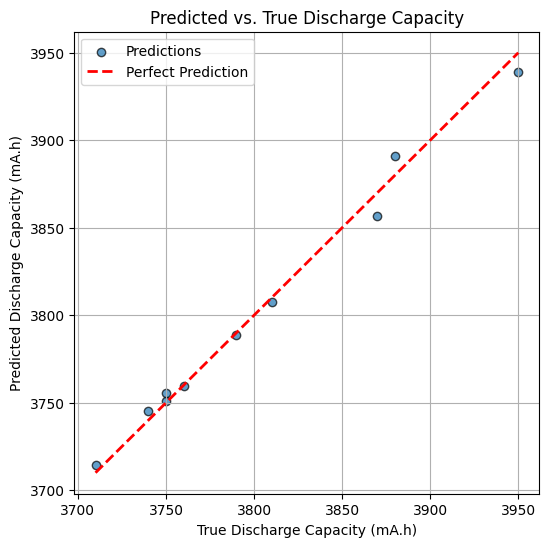

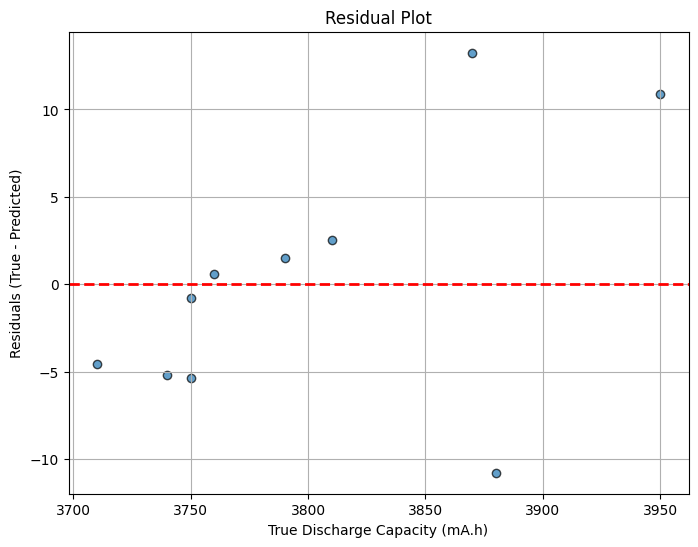

In [12]:
# Assume y_test are the true target values and y_pred_mean are your ensemble predictions.
# Also assume y_pred_std contains your ensemble standard deviation estimates.

# Scatter plot: Predicted vs. True
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_mean, alpha=0.7, edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Discharge Capacity (mA.h)')
plt.ylabel('Predicted Discharge Capacity (mA.h)')
plt.title('Predicted vs. True Discharge Capacity')
plt.legend()
plt.grid(True)

# Residual plot: Error vs. True values
residuals = y_test - y_pred_mean
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('True Discharge Capacity (mA.h)')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.grid(True)

In [13]:
print("Predictions shape:", y_pred_mean.shape)
print("Uncertainty shape (std):", y_pred_std.shape)


Predictions shape: (10,)
Uncertainty shape (std): (10,)


### Attempting to test the model against other datasets

In [14]:
import joblib

In [15]:
# Suppose you have your list of models: models = [model1, model2, ... model10]
joblib.dump(models, "../models/gb_ensemble.pkl")

['../models/gb_ensemble.pkl']

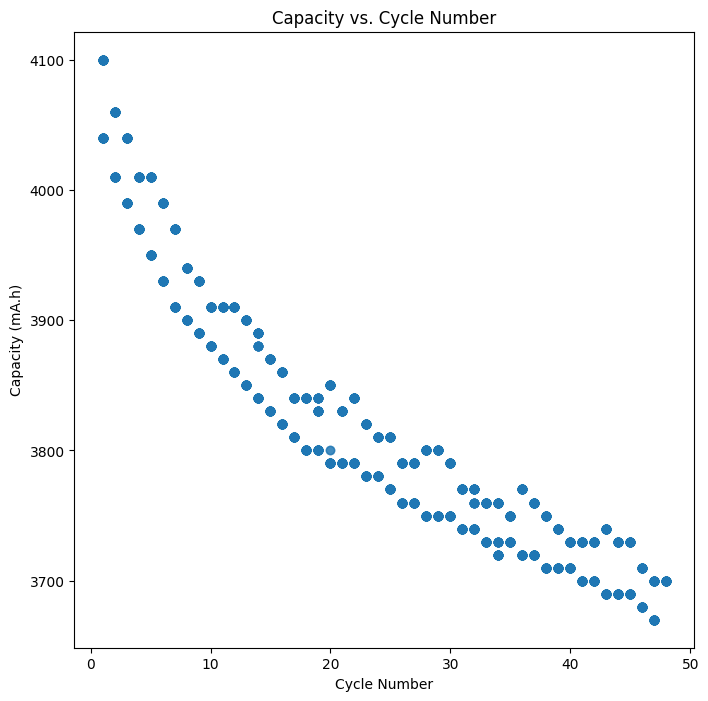

In [16]:
df = load_data("03-06-24", "A2.csv")
  
plot_degradation(df[(df['freq/Hz'] > 0.2) & (df['freq/Hz'] <= 20000)])

In [17]:
X, y = preprocess_SAV(df)

Most common unique frequency count is 70, so expected EIS state vector length is 140.
Skipping cycle 48.0: has 33 unique frequency points, expected 70.
Final dataset shapes:
  X: (47, 149)
  y: (47,)
X shape: (47, 149)
y shape: (47,)


In [18]:
# 4) Load ensemble of models from the .pkl file
models = joblib.load("../models/gb_ensemble.pkl")
# 'models' should be a list of 10 GradientBoostingRegressor objects

In [19]:
# 5) Use the ensemble to predict on X
#    For each model, predict on X, then collect results
preds_ensemble = [model.predict(X) for model in models]  # list of arrays
preds_ensemble = np.array(preds_ensemble)                # shape = (num_models, num_samples)

# 6) Compute the mean and std across the ensemble for each sample
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

# 7) Evaluate or inspect predictions
print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

# If you have ground truth y for these new data, you can evaluate error:


Mean predictions: [3987.63740844 3982.72878435 3966.29045278 3960.80040229 3931.21929544
 3929.84118145 3917.4056486  3906.75099959 3900.08857729 3892.48217439
 3879.31530479 3879.79189331 3884.02197831 3868.42798094 3841.42269805
 3838.07653241 3818.97541411 3813.47173905 3813.64286434 3824.55950714
 3812.25134597 3803.5346596  3787.47567374 3784.27570989 3778.55397612
 3767.51780355 3767.52542385 3772.47120569 3769.06965698 3763.72476982
 3751.86548896 3750.59477461 3736.52463077 3736.5766567  3736.57482268
 3742.58381226 3727.86561102 3727.98417493 3710.6125441  3710.74330359
 3700.61700224 3700.7561321  3700.73686927 3698.76596899 3697.67834305
 3697.47028939 3697.69661963]
Prediction std: [ 7.42801891  5.02246129  6.24093789  8.81543963 10.33939404 10.90450317
  3.58495588  5.17579278  7.01166765  2.01985588 10.86087163 10.86250137
 11.62526592 16.63205316  8.94240795  8.07927197  5.39938826  5.40017599
  5.40017599  4.63411778  6.70290827  5.8699969   5.15814378  4.96333163
  6.5

In [20]:
rmse, r2, mse, mae = evaluate_model(y, y_pred_mean)
print(f"RMSE: {rmse} \n, R2: {r2} \n, MSE: {mse} \n, MAE: {mae}")

RMSE: 15.399304989262765 
, R2: 0.9728290738050716 
, MSE: 237.13859415233307 
, MAE: 12.002180816228188
